In [21]:
import numpy as np
import scipy.stats as stats             # For distribution functions
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d # For 3D graphs

plt.rcParams['axes.axisbelow'] = True   # Set axes and grid elements to be below the figure
# %matplotlib widget

## Kou Jump Diffusion Model

![KJD Model](kou_jump_diffusion.png)

In [22]:
N_SIMS = 20000                           # FIXME: number of simulations
N_STEPS = 200                            # FIXME: number of steps (excluding t = 0)
T = 1                                    # FIXME: time horizon
S0 = 10                                   # FIXME: initial stock price

# GBM parameters
MU = 0.5                                 # FIXME: expected return
SIGMA = 0.2                              # FIXME: volatility

MU = MU - 0.5 * SIGMA**2                 # fix drift coefficient for ABM

# Jump parameters
LAMBDA = 0.5                             # FIXME: rate of jump arrival, controls level of excess kurtosis
P = 0.4                                  # FIXME: probability of positive jump
ETA1 = 4                                 # FIXME: parameter of positive jump size
ETA2 = 3                                 # FIXME: parameter of negative jump size

dt = T / N_STEPS                         # time step
t_steps = np.linspace(0, T, N_STEPS + 1) # vector of time points

# Simulation ==============================================================================================
# Compute Poisson process increments
N = np.random.poisson(LAMBDA * dt, (N_STEPS, N_SIMS))

# Generate Bilateral Exponential R.V.       
U = np.random.uniform(size = (N_STEPS, N_SIMS))
J = np.where(U >= 1 - P, -1 / ETA1 * np.log((1 - U) / P), 1 / ETA2 * np.log(U / (1 - P)) * (U < 1 - P))
J *= N

# Add jump increments to ABM increments    
S = MU * dt + SIGMA * np.sqrt(dt) * np.random.randn(N_STEPS, N_SIMS) + J
S = np.vstack([np.zeros(N_SIMS), np.cumsum(S, axis=0)])
S += S0

# Statistics ==============================================================================================
exact_mean = (MU + LAMBDA * (P / ETA1 - (1 - P) / ETA2)) * t_steps + S0
exact_var = (SIGMA**2 + 2 * LAMBDA * (P / (ETA1**2) + (1 - P) / (ETA2**2))) * t_steps
exact_skew = 6 * LAMBDA * (P / ETA1**3 - (1 - P) / ETA2**3) / (np.power(SIGMA**2 + 2 * LAMBDA * (P / ETA1**2 + (1 - P) / ETA2**2), 3 / 2) * np.sqrt(t_steps))
exact_kurt = 24 * LAMBDA * (P / ETA1**4 + (1 - P) / ETA2**4) / (np.power((SIGMA**2 + 2 * LAMBDA * (P / ETA1**2 + (1 - P) / ETA2**2)), 2) * t_steps)

C:\Users\Jason\AppData\Local\Temp\ipykernel_21452\1728387258.py:40: RuntimeWarning: divide by zero encountered in divide
  exact_skew = 6 * LAMBDA * (P / ETA1**3 - (1 - P) / ETA2**3) / (np.power(SIGMA**2 + 2 * LAMBDA * (P / ETA1**2 + (1 - P) / ETA2**2), 3 / 2) * np.sqrt(t_steps))
C:\Users\Jason\AppData\Local\Temp\ipykernel_21452\1728387258.py:41: RuntimeWarning: divide by zero encountered in divide
  exact_kurt = 24 * LAMBDA * (P / ETA1**4 + (1 - P) / ETA2**4) / (np.power((SIGMA**2 + 2 * LAMBDA * (P / ETA1**2 + (1 - P) / ETA2**2)), 2) * t_steps)


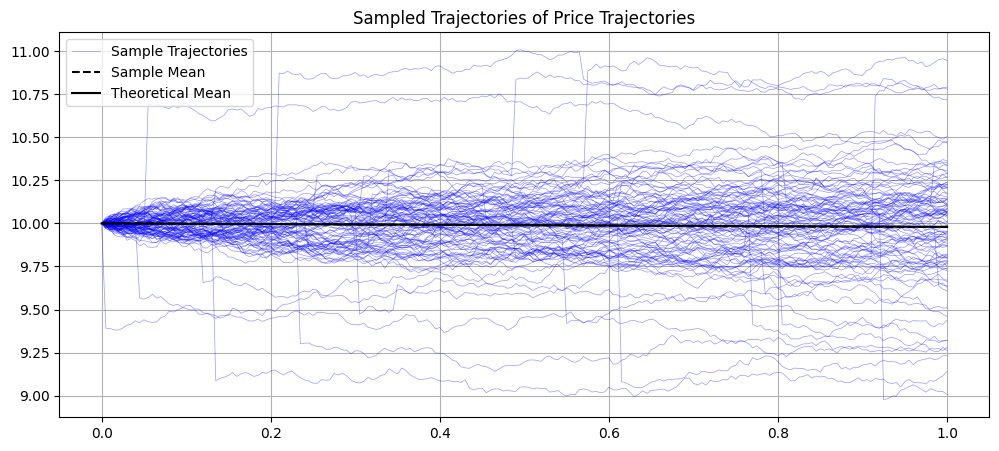

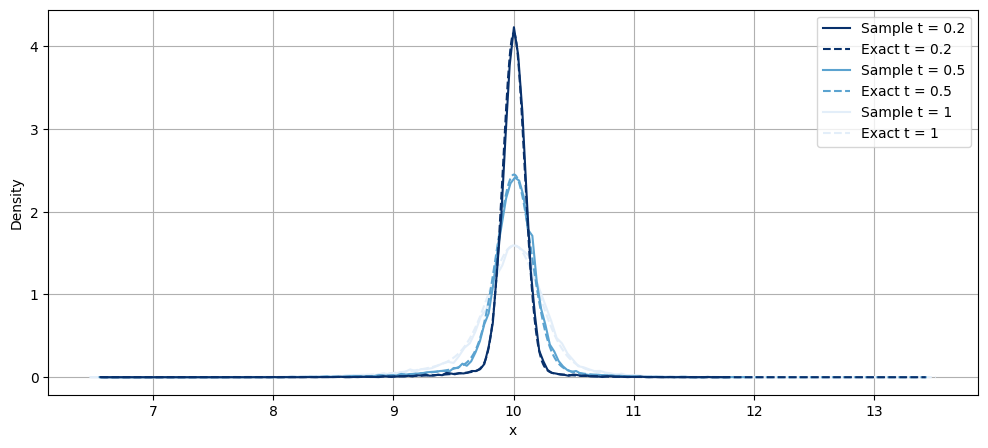

In [23]:
# Trajectories & Slices
# Price Trajectoris ==========================================================================
plt.figure(figsize = (12, 5), clear = True)

plt.title("Sampled Trajectories of Price Trajectories")
plt.plot(t_steps, S[:,:100], color = "blue", alpha = 0.4, lw = 0.5, label = "Sample Trajectories")
plt.plot(t_steps, S.mean(axis = 1), color = "black", linestyle = "--", label = "Sample Mean")
plt.plot(t_steps, exact_mean, color = "black", linestyle = "-", label = "Theoretical Mean")

handles, labels = plt.gca().get_legend_handles_labels() # This gets the handles and labels of the current axes
by_label = dict(zip(labels, handles)) # dict(zip(keys, values)) is a way to create a dictionary from two lists
plt.legend(by_label.values(), by_label.keys())
plt.grid()
plt.show()

# Slices =====================================================================================
SLICES = [0.2, 0.5, 1]       # FIXME: times to plot
# SLICES = [1]       # FIXME: times to plot

plt.figure(figsize = (12, 5), clear = True)

colors = plt.cm.Blues(np.linspace(0.1, 1, len(SLICES))) # Inverse grey color direction

def kjd_charfunc(xi, t, mu, lam, sigma, eta1, eta2, p):
    gamma = mu - (sigma**2) / 2
    jump_component = p * eta1 / (eta1 - 1j*xi) + (1-p) * eta2 / (eta2 + 1j*xi) - 1
    return np.exp(1j * xi * gamma * t - (sigma**2) * xi**2 * t / 2 + lam * t * jump_component)

for i, time in enumerate(SLICES[::-1]): # Reverse slices so the nearest time is plotted at the front layer
    p, x = np.histogram(S[int(time * N_STEPS)], bins = 150, density = True)
    x = (x[:-1] + x[1:]) / 2 # Get the middle point of each bin

    # Recover exact pdf
    N = 1024
    x_centred = x - S0 # Center the pdf around 0
    lower = -max(abs(x_centred.min()), abs(x_centred.max()))
    upper = -lower
    L = upper - lower
    dx = L / N
    xs = np.arange(lower, upper, dx)
    dxi = 2 * np.pi / L
    xis = np.arange(-N/2, N/2) * dxi
    F = kjd_charfunc(xi = xis, t = time, mu = MU, lam = LAMBDA, sigma = SIGMA, eta1 = ETA1, eta2 = ETA2, p = P)
    f = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(F))).real / L    

    plt.plot(xs + S0, f, color = colors[i], linestyle = "--", label = f"Exact t = {time}")
    plt.plot(x, p, color = colors[i], linestyle = "-", label = f"Sample t = {time}")

# Reverse legend order
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])

plt.xlabel("x")
plt.ylabel("Density")
plt.grid()
plt.show()

C:\Users\Jason\AppData\Local\Temp\ipykernel_21452\1012027029.py:22: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ax[1, 0].plot(t_steps, stats.skew(S, axis = 1), color = "red", label = "Sample Skewness")
C:\Users\Jason\AppData\Local\Temp\ipykernel_21452\1012027029.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ax[1, 1].plot(t_steps, stats.kurtosis(S, axis = 1), color = "red", label = "Sample Kurtosis")


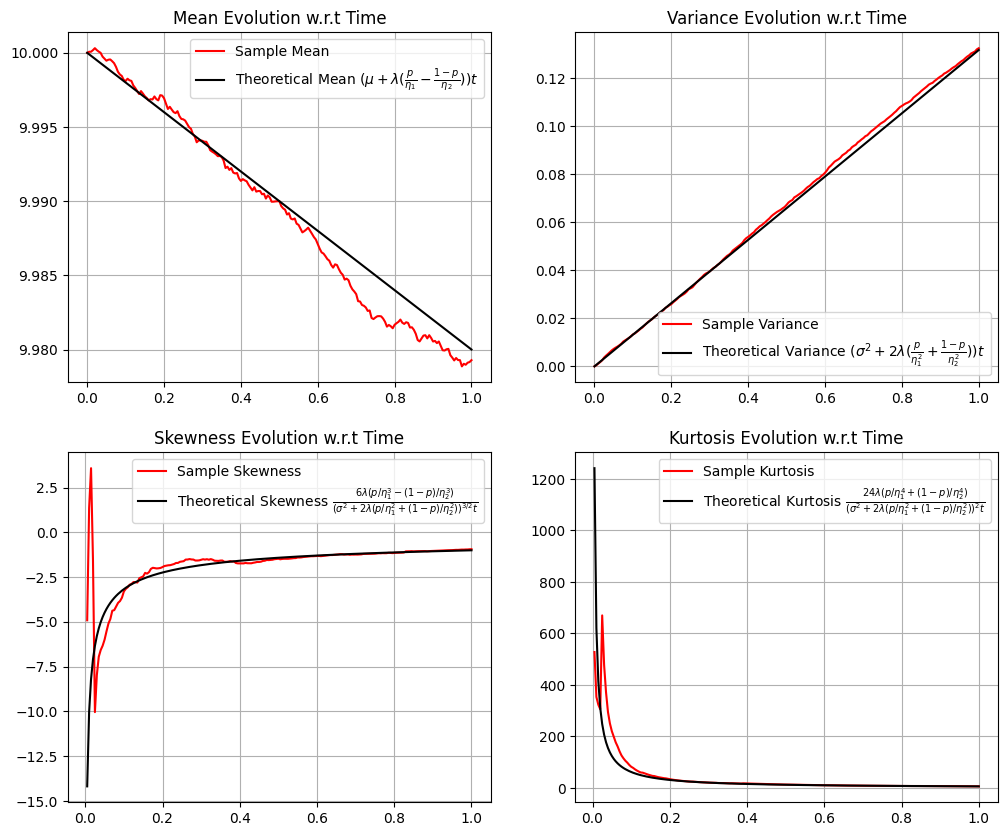

In [24]:
# Plotting Mean and Variance Convergence ==============================================
fig, ax = plt.subplots(2, 2, figsize = (12, 10), clear = True)

# Mean Convergence --------------------------------------------------------------------
ax[0, 0].set_title("Mean Evolution w.r.t Time")
ax[0, 0].plot(t_steps, S.mean(axis = 1), color = "red", label = "Sample Mean")
ax[0, 0].plot(t_steps, exact_mean, color = "black", label = r"Theoretical Mean $(\mu+\lambda(\frac{p}{\eta_1}-\frac{1-p}{\eta_2}))t$")

ax[0, 0].grid()
ax[0, 0].legend()

# Variance Convergence ----------------------------------------------------------------
ax[0, 1].set_title("Variance Evolution w.r.t Time")
ax[0, 1].plot(t_steps, S.var(axis = 1), color = "red", label = "Sample Variance")
ax[0, 1].plot(t_steps, exact_var, color = "black", label = r"Theoretical Variance $(\sigma^2+2\lambda(\frac{p}{\eta_1^2}+\frac{1-p}{\eta_2^2}))t$")

ax[0, 1].grid()
ax[0, 1].legend()

# Skewness Convergence ----------------------------------------------------------------
ax[1, 0].set_title("Skewness Evolution w.r.t Time")
ax[1, 0].plot(t_steps, stats.skew(S, axis = 1), color = "red", label = "Sample Skewness")
ax[1, 0].plot(t_steps, exact_skew, color = "black", label = r"Theoretical Skewness $\frac{6\lambda(p/\eta_1^3-(1-p)/\eta_2^3)}{(\sigma^2+2\lambda(p/\eta_1^2+(1-p)/\eta_2^2))^{3/2}t}$")
ax[1, 0].grid()
ax[1, 0].legend()

# Kurtosis Convergence ----------------------------------------------------------------
ax[1, 1].set_title("Kurtosis Evolution w.r.t Time")
ax[1, 1].plot(t_steps, stats.kurtosis(S, axis = 1), color = "red", label = "Sample Kurtosis")
ax[1, 1].plot(t_steps, exact_kurt, color = "black", label = r"Theoretical Kurtosis $\frac{24\lambda(p/\eta_1^4+(1-p)/\eta_2^4)}{(\sigma^2+2\lambda(p/\eta_1^2+(1-p)/\eta_2^2))^2t}$")
ax[1, 1].grid()
ax[1, 1].legend()

plt.show()

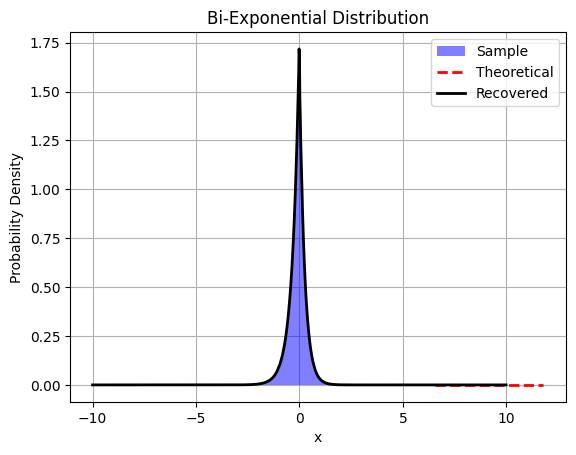

In [25]:
def rbiexp(n, eta1, eta2, p):
    """
    Generate n random variables from a bi-exponential distribution
    """
    u = np.random.uniform(size = n)
    # return np.where(u < p, np.random.exponential(scale = eta1, size = n), -np.random.exponential(scale = eta2, size = n))
    return -1 / eta1 * np.log((1 - u) / p) * (u >= 1 - p) + 1 / eta2 * np.log(u / (1 - p)) * (u < 1 - p)

def dbiexp(x, eta1, eta2, p):
    """
    Compute the probability density function of a bi-exponential distribution
    """
    return p * eta1 * np.exp(-eta1 * x) * (x >= 0) + (1 - p) * eta2 * np.exp(eta2 * x) * (x < 0)

def biexp_charfunc(u, eta1, eta2, p):
    """
    Compute the characteristic function of a bi-exponential distribution
    """
    return p * eta1 / (eta1 - 1j * u) + (1 - p) * eta2 / (eta2 + 1j * u)

sample = rbiexp(100000, ETA1, ETA2, P)

N = 1024
lower = -10
upper = 10
L = upper - lower
dx = L / N
xs = np.arange(lower, upper, dx)
dxi = 2 * np.pi / L
xi = np.arange(-N/2, N/2) * dxi

F = biexp_charfunc(xi, ETA1, ETA2, P)
f = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(F))).real
f = f / (np.sum(f) * dx)

plt.hist(sample, bins=100, density=True, color='blue', alpha=0.5, label='Sample')
plt.plot(x, dbiexp(x, ETA1, ETA2, P), color='red', linestyle='--', linewidth=2, label = 'Theoretical')
plt.plot(xs, f, color='black', linestyle='-', linewidth=2, label = 'Recovered')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Bi-Exponential Distribution')
plt.legend()
plt.grid()
plt.show()